In [1]:
# imports
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from esem import gp_model
from eofs.xarray import Eof
from utils import *
import gpflow

2024-11-22 05:29:07.339814: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732278547.351846  251285 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732278547.355785  251285 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-22 05:29:07.370371: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# list of experiment data used for training

train_files= ['ssp126', 'ssp370', 'ssp585', 'historical', 'hist-GHG', 'hist-aer']

### prepare data

In [3]:
# get data
Xtrain, eof_solvers = get_Xtrain(train_files)
Ytrain_pr90 = get_Ytrain(train_files)['pr90'].values.reshape(-1, 96*144)

Xtest = get_Xtest('ssp245', eof_solvers)
Ytest = xr.open_dataset('../test/outputs_ssp245.nc').compute()
pr90_truth = 86400 * Ytest['pr90'].mean('member') # convert pr to mm/day, default unit is kg/m²/s

In [4]:
# drop rows including nans
train_nan_mask = Xtrain.isna().any(axis=1).values
Xtrain = Xtrain.dropna(axis=0, how='any')
Ytrain_pr90 = Ytrain_pr90[~train_nan_mask]
assert Xtrain.shape[0]==Ytrain_pr90.shape[0]

test_nan_mask = Xtest.isna().any(axis=1).values
Xtest = Xtest.dropna(axis=0, how='any')
pr90_truth = pr90_truth[~test_nan_mask]

In [5]:
# Standardize predictor fields requiring standardization (non-EOFs)
train_CO2_mean, train_CO2_std = Xtrain['CO2'].mean(), Xtrain['CO2'].std()
train_CH4_mean, train_CH4_std = Xtrain['CH4'].mean(), Xtrain['CH4'].std()

Xtrain['CO2'] = (Xtrain['CO2'] - train_CO2_mean) / train_CO2_std
Xtrain['CH4'] = (Xtrain['CH4'] - train_CH4_mean) / train_CH4_std

Xtest['CO2'] = (Xtest['CO2'] - train_CO2_mean) / train_CO2_std
Xtest['CH4'] = (Xtest['CH4'] - train_CH4_mean) / train_CH4_std

In [6]:
# Standardize predictand fields
train_pr90_mean, train_pr90_std = Ytrain_pr90.mean(), Ytrain_pr90.std()
Ytrain_pr90 = (Ytrain_pr90 - train_pr90_mean) / train_pr90_std

### Model

In [7]:
kernel_CO2 = gpflow.kernels.Matern32(active_dims=[0]) # active_dims specifies which dimension the kernel is applied to
kernel_CH4 = gpflow.kernels.Matern32(active_dims=[1])

kernel_BC = gpflow.kernels.Matern32(lengthscales=5 * [1.], active_dims=[2, 3, 4, 5, 6])
kernel_SO2 = gpflow.kernels.Matern32(lengthscales=5 * [1.], active_dims=[7, 8, 9, 10, 11])

kernel = kernel_CO2 + kernel_CH4 + kernel_BC + kernel_SO2

I0000 00:00:1732278556.287521  251285 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79379 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:01:00.0, compute capability: 8.0


In [8]:
np.random.seed(5)

"""
In Gaussian Processes, a mean function represents the "prior mean" or the expected value
of the function at any input point before observing any data.
"""
mean = gpflow.mean_functions.Constant()

model = gpflow.models.GPR(data=(Xtrain.astype(np.float64), # cast to float64 because gpflow requires numerical stability
                                Ytrain_pr90.astype(np.float64)),
                          kernel = kernel,
                          mean_function = mean)

In [9]:
# define optimizer
optimizer = gpflow.optimizers.Scipy()

# train
optimizer.minimize(model.training_loss,
                   variables=model.trainable_variables,
                   options=dict(disp=True, maxiter=1000))

I0000 00:00:1732278560.829441  251345 cuda_solvers.cc:178] Creating GpuSolver handles for stream 0x5649e4255d30
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.46798D+07    |proj g|=  6.21221D+05

At iterate    1    f=  1.45440D+07    |proj g|=  1.01968D+05

At iterate    2    f=  1.45285D+07    |proj g|=  9.99489D+04

At iterate    3    f=  1.44452D+07    |proj g|=  3.58827D+05

At iterate    4    f=  1.42922D+07    |proj g|=  6.25518D+05

At iterate    5    f=  1.41021D+07    |proj g|=  4.52557D+05

At iterate    6    f=  1.40326D+07    |proj g|=  1.06766D+05

At iterate    7    f=  1.40282D+07    |proj g|=  1.22619D+04

At iterate    8    f=  1.40276D+07    |proj g|=  1.43959D+04

At iterate    9    f=  1.40264D+07    |proj g|=  4.71371D+04

At iterate   10    f=  1.40240D+07    |proj g|=  9.25431D+04

At iterate   11    f=  1.40186D+07    |proj g|=  1.48191D+05

At iterate   12    f=  1.40100D+07    |proj g|=  1.84034D+05

At iterate   13    f=  1.4

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 13973466.47362798
        x: [ 4.516e+00 -1.593e-01 ...  2.646e-01  2.487e-02]
      nit: 329
      jac: [-1.162e+01  4.614e+01 ... -4.105e+02  4.527e+01]
     nfev: 391
     njev: 391
 hess_inv: <18x18 LbfgsInvHessProduct with dtype=float64>

### make prediction

In [10]:
# predict
standard_posterior_mean, standard_posterior_var = model.predict_y(Xtest.values) # predicted mean of GP, predicted variance of GP
posterior_mean = standard_posterior_mean * train_pr90_std + train_pr90_mean # transform mean prediction to original scale
posterior_stddev = np.sqrt(standard_posterior_var) * train_pr90_std # transform variance prediction to original scale standard deviation

In [11]:
# put output back into xarray format for calculating RMSE/plotting
posterior_pr90 = np.reshape(posterior_mean, [86, 96, 144])
posterior_pr90_stddev = np.reshape(posterior_stddev, [86, 96, 144])

posterior_pr90_data = xr.DataArray(posterior_pr90, dims=pr90_truth.dims, coords=pr90_truth.coords)
posterior_pr90_std_data = xr.DataArray(posterior_pr90_stddev, dims=pr90_truth.dims, coords=pr90_truth.coords)

In [12]:
# Compute RMSEs
print(f"RMSE at 2050: {get_rmse(pr90_truth[35], posterior_pr90_data[35])}")
print(f"RMSE at 2100: {get_rmse(pr90_truth[85], posterior_pr90_data[85])}")
print(f"RMSE 2045-2055: {get_rmse(pr90_truth[30:41], posterior_pr90_data[30:41]).mean()}")
print(f"RMSE 2090-2100: {get_rmse(pr90_truth[75:], posterior_pr90_data[75:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(pr90_truth[35:], posterior_pr90_data[35:]).mean()}")

# RMSE for average field over last 20 years
print(f"RMSE average last 20y: {get_rmse(pr90_truth[-20:].mean(dim='time'), posterior_pr90_data[-20:].mean(dim='time'))}")

RMSE at 2050: 1.2130858727783458
RMSE at 2100: 1.6382599959380366
RMSE 2045-2055: 1.4754150986257621
RMSE 2090-2100: 1.5208997748470332
RMSE 2050-2100: 1.5492741600620086
RMSE average last 20y: 0.48368783868907234


[Text(0.5, 1.0, 'Difference')]

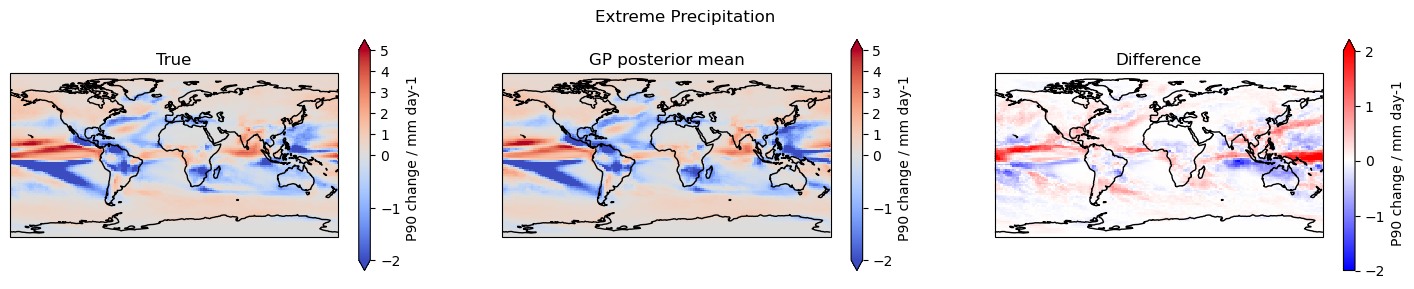

In [13]:
from matplotlib import colors
# plotting predictions
divnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=5)
diffnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=2)

## Temperature
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(18, 3))
fig.suptitle('Extreme Precipitation')

# Test
plt.subplot(131, projection=proj)
pr90_truth.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", norm=divnorm,
                              cbar_kwargs={"label":"P90 change / mm day-1 "})
plt.gca().coastlines()
plt.setp(plt.gca(), title='True')

# Emulator
plt.subplot(132, projection=proj)
posterior_pr90_data.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", norm=divnorm,
                       cbar_kwargs={"label":"P90 change / mm day-1 "})
plt.gca().coastlines()
plt.setp(plt.gca(), title='GP posterior mean')

# Difference
difference = pr90_truth - posterior_pr90_data
plt.subplot(133, projection=proj)
difference.sel(time=slice(2050,None)).mean('time').plot(cmap="bwr", norm=diffnorm,
                cbar_kwargs={"label":"P90 change / mm day-1 "})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Difference')

In [14]:
model

name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.c,Parameter,Identity,,True,"(1,)",float64,[0.02486868]
GPR.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.6166829861364803
GPR.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,4.52729
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,1.83991697104977e-52
GPR.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,96.65484
GPR.kernel.kernels[2].variance,Parameter,Softplus,,True,(),float64,0.016885402763358048
GPR.kernel.kernels[2].lengthscales,Parameter,Softplus,,True,"(5,)",float64,"[1.73173, 125.32431, 79.52744..."
GPR.kernel.kernels[3].variance,Parameter,Softplus,,True,(),float64,0.25427230196286643
GPR.kernel.kernels[3].lengthscales,Parameter,Softplus,,True,"(5,)",float64,"[6.60297, 7.39649, 13.06545..."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.834159241121816
